In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy import interpolate
from scipy.optimize import curve_fit

In [2]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [3]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [4]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')

In [5]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [6]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")

In [7]:
spec3d = surf3d.define_SpectralAnalysis()

In [8]:
FFT_spec = spec3d.spectrum()
# 3d array 

In [9]:
FFT_spec.shape

(1200, 66, 66)

In [10]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th

In [11]:
%matplotlib widget

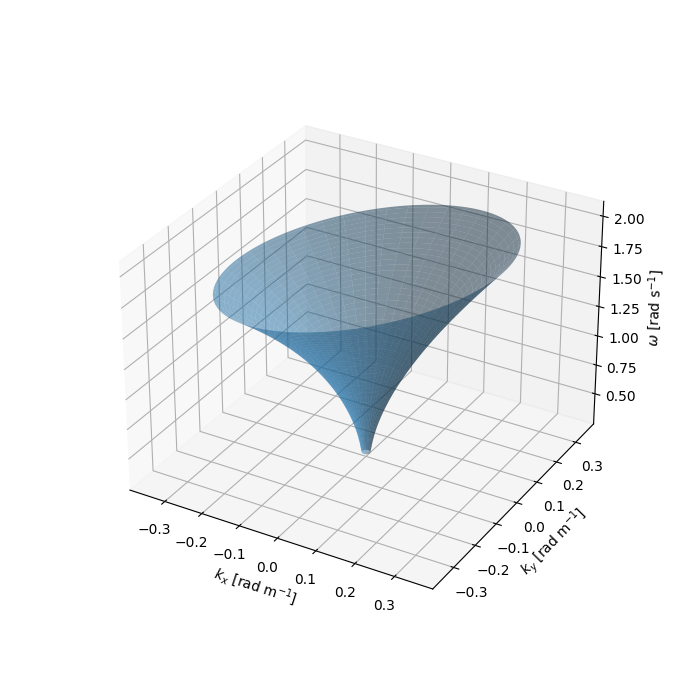

In [12]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
kx, ky, ww, kk, th = plot_disp_shell(axes, h=100, z=z, U=U, psi=0)

In [13]:
ww

array([[0.27390735, 0.27390664, 0.2739045 , ..., 0.27390538, 0.27390704,
        0.27390727],
       [0.36619278, 0.36619123, 0.3661866 , ..., 0.3661885 , 0.3661921 ,
        0.36619261],
       [0.43702509, 0.43702244, 0.4370145 , ..., 0.43701776, 0.43702392,
        0.43702479],
       ...,
       [2.04614003, 2.04584845, 2.04497445, ..., 2.04533326, 2.04601157,
        2.04610705],
       [2.06471485, 2.0644169 , 2.0635238 , ..., 2.06389046, 2.06458358,
        2.06468114],
       [2.08321763, 2.08291329, 2.082001  , ..., 2.08237553, 2.08308355,
        2.08318321]])

In [14]:
matrix_posi_kx = kk*np.cos(0)
positive_kx = matrix_posi_kx[:,0]
positive_kx

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [15]:
matrix_neg_kx = kk*np.cos(3.15)
negative_kx = matrix_neg_kx[:,0]
negative_kx

array([-0.00999965, -0.01499947, -0.01999929, -0.02499912, -0.02999894,
       -0.03499876, -0.03999859, -0.04499841, -0.04999823, -0.05499806,
       -0.05999788, -0.0649977 , -0.06999753, -0.07499735, -0.07999717,
       -0.084997  , -0.08999682, -0.09499664, -0.09999647, -0.10499629,
       -0.10999611, -0.11499594, -0.11999576, -0.12499558, -0.12999541,
       -0.13499523, -0.13999505, -0.14499488, -0.1499947 , -0.15499452,
       -0.15999435, -0.16499417, -0.16999399, -0.17499382, -0.17999364,
       -0.18499346, -0.18999329, -0.19499311, -0.19999293, -0.20499275,
       -0.20999258, -0.2149924 , -0.21999222, -0.22499205, -0.22999187,
       -0.23499169, -0.23999152, -0.24499134, -0.24999116, -0.25499099,
       -0.25999081, -0.26499063, -0.26999046, -0.27499028, -0.2799901 ,
       -0.28498993, -0.28998975, -0.29498957, -0.2999894 , -0.30498922,
       -0.30998904, -0.31498887, -0.31998869, -0.32498851, -0.32998834,
       -0.33498816, -0.33998798, -0.34498781])

In [16]:
th

array([[0.  , 0.05, 0.1 , ..., 6.2 , 6.25, 6.3 ],
       [0.  , 0.05, 0.1 , ..., 6.2 , 6.25, 6.3 ],
       [0.  , 0.05, 0.1 , ..., 6.2 , 6.25, 6.3 ],
       ...,
       [0.  , 0.05, 0.1 , ..., 6.2 , 6.25, 6.3 ],
       [0.  , 0.05, 0.1 , ..., 6.2 , 6.25, 6.3 ],
       [0.  , 0.05, 0.1 , ..., 6.2 , 6.25, 6.3 ]])

In [17]:
kx

array([[0.01      , 0.0099875 , 0.00995004, ..., 0.00996542, 0.00999449,
        0.00999859],
       [0.015     , 0.01498125, 0.01492506, ..., 0.01494813, 0.01499174,
        0.01499788],
       [0.02      , 0.01997501, 0.01990008, ..., 0.01993084, 0.01998899,
        0.01999717],
       ...,
       [0.335     , 0.33458134, 0.3333264 , ..., 0.3338416 , 0.33481556,
        0.33495264],
       [0.34      , 0.33957509, 0.33830142, ..., 0.33882431, 0.3398128 ,
        0.33995194],
       [0.345     , 0.34456884, 0.34327644, ..., 0.34380702, 0.34481005,
        0.34495123]])

In [18]:
kx[:,0]

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [19]:
kx[:,0]

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [20]:
plt.plot(kx[:,0], ww[:,0])

plt.scatter(np.array([0.012693303650867849]), 
            np.array([0.8272860654453118]), 
            color= 'red', s=40, label="New Trips")

plt.legend()
plt.grid(True)
plt.xlabel("k")
plt.ylabel("w")

Text(0.06457909074667251, 0.5, 'w')

In [21]:
import numpy as np

# Assuming you have your arrays kx, ky, and ww

# Find the indices where ky is equal to 0
kx_zero_indices = np.where(kx == 0)

# Extract the corresponding values of kx and ww where ky is equal to 0
ky_at_ky_zero = ky[kx_zero_indices]
ww_at_ky_zero = ww[kx_zero_indices]

# Print or use the values as needed
print("ky values when kx is 0:", ky_at_ky_zero)
print("ww values when kx is 0:", ww_at_ky_zero)


ky values when kx is 0: []
ww values when kx is 0: []


In [22]:
ky[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
kx[:,0]

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [24]:
ww[:,0]

array([0.27390735, 0.36619278, 0.43702509, 0.49510166, 0.54561073,
       0.59131099, 0.63367069, 0.67351859, 0.7113642 , 0.74754938,
       0.78232095, 0.81586702, 0.84833652, 0.87985055, 0.91050941,
       0.94039747, 0.96958647, 0.99813805, 1.0261056 , 1.05353569,
       1.08046925, 1.10694244, 1.13298737, 1.15863273, 1.18390424,
       1.20882506, 1.23341613, 1.25769647, 1.28168336, 1.30539263,
       1.32883875, 1.35203501, 1.37499366, 1.39772602, 1.42024256,
       1.44255299, 1.46466632, 1.48659098, 1.5083348 , 1.52990512,
       1.5513088 , 1.5725523 , 1.59364167, 1.6145826 , 1.63538046,
       1.65604032, 1.67656696, 1.69696492, 1.71723848, 1.73739171,
       1.75742847, 1.77735244, 1.79716711, 1.81687581, 1.8364817 ,
       1.85598782, 1.87539706, 1.89471217, 1.91393581, 1.9330705 ,
       1.95211868, 1.97108266, 1.98996468, 2.00876689, 2.02749135,
       2.04614003, 2.06471485, 2.08321763])

In [25]:
plt.plot(kx[:,0], ww[:,0])

plt.scatter(np.array([0.04301255187, 0.3066398521707972, 0.2063441768530679, 0.10080238071381617]), 
            np.array([0.6754424205218053, 1.7121679962064364, 1.4084807063594234, 1.0000736613927508]), 
            color= 'red', s=40, label="New Trips")

In [26]:
kx.shape

(68, 127)

In [27]:
ww.shape

(68, 127)

In [28]:
FFT_spec[0]

array([[8.08448245e-11, 8.04448126e-11, 7.92351793e-11, ...,
        7.69202100e-11, 7.92351793e-11, 8.04448126e-11],
       [8.26274044e-11, 8.40336723e-11, 8.45450464e-11, ...,
        7.23470679e-11, 7.69223490e-11, 8.02539750e-11],
       [8.80727465e-11, 9.15182353e-11, 9.42511780e-11, ...,
        7.09461490e-11, 7.84368641e-11, 8.38550234e-11],
       ...,
       [9.84704564e-11, 9.17370404e-11, 8.38289587e-11, ...,
        1.15278037e-10, 1.09487819e-10, 1.04127689e-10],
       [8.80727465e-11, 8.38550234e-11, 7.84368641e-11, ...,
        9.70534669e-11, 9.42511780e-11, 9.15182353e-11],
       [8.26274044e-11, 8.02539750e-11, 7.69223490e-11, ...,
        8.47510660e-11, 8.45450464e-11, 8.40336723e-11]])

In [29]:
kx = spec3d.kx
ky = spec3d.ky 
w = spec3d.w

In [30]:
len(w)

1200

In [31]:
FFT_spec = spec3d.spectrum()
# 3d array 

In [32]:
def plot_kx_w_spec(kx, w, spec, radial_filter=False, extent=None, ax=None, colorbar=True, spec_min=None, spec_max=None, cmap='viridis'):    
    if not spec_min is None:
        data = np.where(spec<spec_min, spec_min, spec)
    if not spec_max is None:
        data = np.where(spec>spec_max, spec_max, spec)
    ax = plotting_interface.plot_3d_as_2d(kx, w, spec, radial_filter, extent, ax, aspect='auto', colorbar=colorbar, data_min=spec_min, data_max=spec_max, cmap=cmap)
    ax.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$\omega$')
    return ax

In [33]:
def plot_ky_slice(self, at_ky, ax=None, dB=None, vmin=None, save=False):
        '''
        plots the integrated kx-w-spectrum 
        '''
        if at_ky >= 0:
            i = np.argmin(np.abs(self.ky[len(x)//2:]-at_ky))
            print(at_ky, self.ky[len(x)//2+i], i) 
            plot_kx_w_spec(self.kx, self.w, FFT_spec[:,:,len(x)//2+i], ax=ax)
        else:
            i = np.argmin(np.abs(self.w[:len(x)//2]-at_ky))
            print(at_ky, self.w[i], i) 
            plot_kx_w_spec(self.kx, self.w, FFT_spec[:,:,i], ax=ax)

0 0.0 0


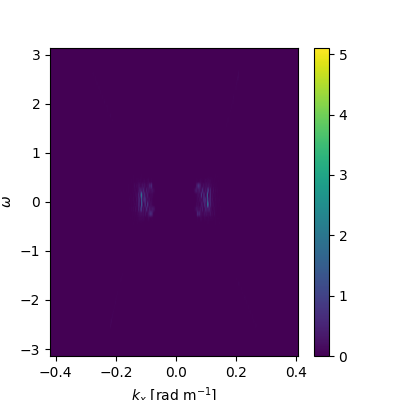

In [34]:
plot_ky_slice(self = spec3d, at_ky = 0)

In [35]:
i = np.argmin(np.abs(spec3d.ky[len(x)//2:]-0))

In [36]:
energies = FFT_spec[:,:,len(x)//2+i]

In [37]:
spec3d.w[758]

0.8272860654453118

In [38]:
max(energies[758])

5.101530532097813

In [39]:
energies[442]

array([6.58749252e-04, 6.60260715e-04, 6.64510897e-04, 6.71310234e-04,
       6.80037114e-04, 6.87021947e-04, 6.66326833e-04, 8.05225378e-04,
       8.26669712e-04, 9.00256940e-04, 8.17730664e-04, 8.79322239e-04,
       1.04631996e-03, 9.26923735e-04, 1.11152691e-03, 1.14620765e-03,
       1.36819549e-03, 1.35336751e-03, 1.59850108e-03, 1.72891305e-03,
       1.91884875e-03, 2.27209144e-03, 2.52669748e-03, 3.35157762e-03,
       4.05235830e-03, 5.50190547e-03, 6.90042569e-03, 8.68126540e-03,
       1.15733809e-02, 2.20422203e-02, 1.23282393e-01, 8.97916165e-02,
       2.98112886e+00, 4.63723012e-01, 5.10153053e+00, 4.00287184e-02,
       4.68732013e-02, 1.91409632e-02, 9.16304712e-03, 7.52565930e-03,
       5.41124311e-03, 4.68247371e-03, 3.72711251e-03, 3.05781714e-03,
       2.64920218e-03, 2.28686834e-03, 2.00600117e-03, 1.68776523e-03,
       1.49994027e-03, 1.31664614e-03, 1.15432421e-03, 1.16846800e-03,
       1.09210829e-03, 1.08045820e-03, 8.66145360e-04, 8.85010101e-04,
      

In [40]:
def find_indices_thresh(array, threshold):
    indices = []

    for i in range(len(array)):
        for j in range(len(array[i])):
            if array[i][j] > threshold:
                indices.append((i, j))

    return indices

# Example usage:
my_2d_array = [
    [1, 2, 5, 3],
    [4, 7, 8, 9],
    [6, 2, 3, 1]
]

threshold_value = 4
result_indices = find_indices_thresh(my_2d_array, threshold_value)

print(f"Indices above {threshold_value}: {result_indices}")


Indices above 4: [(0, 2), (1, 1), (1, 2), (1, 3), (2, 0)]


In [41]:
inde = np.array(result_indices)

In [42]:
inde

array([[0, 2],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 0]])

In [43]:
find_indices_thresh(energies, 5)

[(442, 34), (758, 32)]

In [44]:
energies[442][34]

5.101530532097813

In [45]:
energies[758][32]

5.101530532097813

In [46]:
spec3d.w[758]

0.8272860654453118

In [47]:
spec3d.kx[32]

-0.012693303650867849

In [48]:
ky_0_indices = np.array(find_indices_thresh(energies, 5))
ky_0_indices

array([[442,  34],
       [758,  32]])

In [49]:
spec3d.kx[ ky_0_indices[:,0]]

IndexError: index 442 is out of bounds for axis 0 with size 66

In [50]:
spec3d.w[439]

-0.8429940287132611

In [51]:
spec3d.kx[34]

0.012693303650867849

In [52]:
plt.scatter(spec3d.kx[ ky_0_indices[:,1]], spec3d.w[ ky_0_indices[:,0]])

plt.xlabel("kx")
plt.ylabel("$\omega$")
plt.grid(True)
#plt.legend()

# Try slicing for w

In [53]:
energies.shape

(1200, 66)

In [54]:
# w = 0.3

In [55]:
spec3d.w[657]

0.29845130209103

In [56]:
spec3d.kx

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [57]:
energies[657][32]

0.0003890632001667696

In [58]:
spec3d.kx[32]

-0.012693303650867849

In [59]:
# w = 0.5

In [60]:
spec3d.w[696]

0.5026548245743667

In [61]:
max(energies[696])

0.13862291716310374

In [62]:
energies[696]

array([7.10763302e-06, 7.07305444e-06, 7.08287215e-06, 7.14695821e-06,
       7.29360224e-06, 7.67331154e-06, 1.08548932e-05, 4.83433236e-06,
       4.61138723e-06, 3.94240688e-06, 8.99105881e-06, 1.03749922e-05,
       2.84553600e-06, 1.93984610e-05, 8.57073295e-06, 1.05910645e-05,
       4.61334086e-06, 1.63275729e-05, 1.00435738e-05, 1.77107456e-05,
       1.85136363e-05, 1.98307603e-05, 2.31796813e-05, 2.16589008e-05,
       2.41306455e-05, 2.27262876e-05, 3.53880474e-05, 4.27448197e-05,
       2.49121419e-05, 4.79027312e-05, 5.79009453e-04, 1.94327677e-02,
       9.33307875e-04, 9.12048747e-03, 2.42927382e-02, 1.38622917e-01,
       3.71002257e-03, 1.14322338e-03, 4.13993404e-04, 1.56380079e-04,
       1.68006076e-04, 8.99538326e-05, 7.35084897e-05, 5.04302638e-05,
       2.54789483e-05, 3.03018602e-05, 2.00148563e-05, 2.03461552e-05,
       1.60218233e-05, 2.81806986e-05, 2.71322768e-05, 1.01866778e-05,
       1.26768175e-05, 5.73654189e-06, 1.98835485e-05, 1.18573190e-05,
      

In [63]:
# Find the indices of maximum energy values along the kx axis for each w value
max_energy_indices = np.argmax(energies, axis=1)

# Extract the corresponding kx values for each w value
max_kx_values = spec3d.kx[max_energy_indices]

# Create a dictionary to store the results
result_dict = dict(zip(spec3d.w, max_kx_values))

# Print or use the results as needed
for w_value, max_kx in result_dict.items():
    print(f"For spec3d.w = {w_value}, the corresponding max kx is {max_kx}")


For spec3d.w = -3.141592653589793, the corresponding max kx is 0.0
For spec3d.w = -3.13635666583381, the corresponding max kx is 0.0
For spec3d.w = -3.1311206780778273, the corresponding max kx is 0.0
For spec3d.w = -3.1258846903218442, the corresponding max kx is 0.0
For spec3d.w = -3.120648702565861, the corresponding max kx is 0.0
For spec3d.w = -3.115412714809878, the corresponding max kx is 0.0
For spec3d.w = -3.1101767270538954, the corresponding max kx is 0.0
For spec3d.w = -3.1049407392979123, the corresponding max kx is 0.0
For spec3d.w = -3.099704751541929, the corresponding max kx is 0.0
For spec3d.w = -3.094468763785946, the corresponding max kx is 0.0
For spec3d.w = -3.0892327760299634, the corresponding max kx is 0.0
For spec3d.w = -3.0839967882739803, the corresponding max kx is 0.0
For spec3d.w = -3.078760800517997, the corresponding max kx is 0.0
For spec3d.w = -3.073524812762014, the corresponding max kx is 0.0
For spec3d.w = -3.0682888250060314, the corresponding max

In [64]:
result_dict.items()

dict_items([(-3.141592653589793, 0.0), (-3.13635666583381, 0.0), (-3.1311206780778273, 0.0), (-3.1258846903218442, 0.0), (-3.120648702565861, 0.0), (-3.115412714809878, 0.0), (-3.1101767270538954, 0.0), (-3.1049407392979123, 0.0), (-3.099704751541929, 0.0), (-3.094468763785946, 0.0), (-3.0892327760299634, 0.0), (-3.0839967882739803, 0.0), (-3.078760800517997, 0.0), (-3.073524812762014, 0.0), (-3.0682888250060314, 0.0), (-3.0630528372500483, 0.0), (-3.057816849494065, 0.0), (-3.0525808617380825, 0.0), (-3.0473448739820994, 0.0), (-3.0421088862261163, 0.0), (-3.036872898470133, 0.0), (-3.0316369107141505, 0.0), (-3.0264009229581674, 0.0), (-3.0211649352021843, 0.0), (-3.015928947446201, 0.0), (-3.0106929596902186, 0.0), (-3.0054569719342354, 0.0), (-3.0002209841782523, 0.0), (-2.9949849964222697, 0.0), (-2.9897490086662866, 0.0), (-2.9845130209103035, 0.0), (-2.9792770331543204, 0.0), (-2.9740410453983377, 0.0), (-2.9688050576423546, 0.0), (-2.9635690698863715, 0.0), (-2.9583330821303884

In [65]:
plt.scatter(    np.array([-0.012693303650867849, 0.025386607301735697, 0.038079910952603546, 0.07615982190520709, 0.2665593766682248, 0.34271919857343197,0.20309285841388564]), 
            np.array([0.29845130209103, 0.45029494701453654, 0.5707226654021453, 1.1571532940722404,1.759291886010284, 2.052507200345331, 1.2932889757277977])    )

plt.xlabel("kx")
plt.ylabel("$\omega$")
plt.grid(True)
#plt.legend()

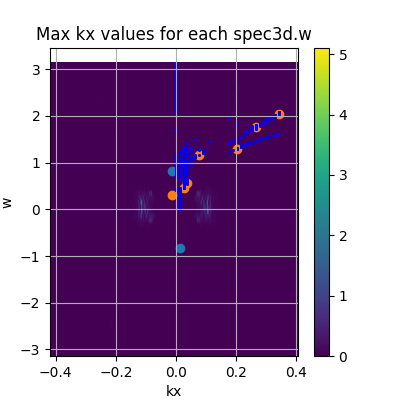

In [66]:
import matplotlib.pyplot as plt

# Assuming 'result_dict' contains the spec3d.w values and corresponding max kx values

# Extract spec3d.w and max kx values from the dictionary
w_values = list(result_dict.keys())
max_kx_values = list(result_dict.values())

# Plot the points
plt.scatter(np.abs(max_kx_values), np.abs(w_values),marker='o', color='blue', s =1)
plt.title('Max kx values for each spec3d.w')
plt.xlabel('kx')
plt.ylabel('w')
#plt.xlim(0,0.4)
#plt.ylim(0,2)
plt.grid(True)
plt.show()


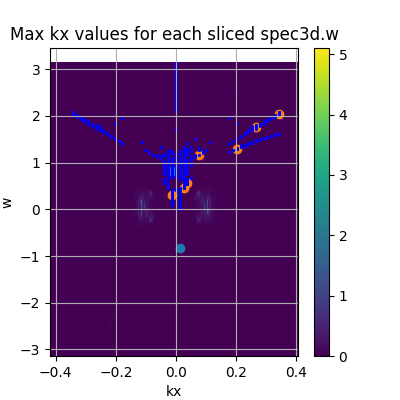

In [67]:
slice_values = np.arange(0.1, 2.1, 0.00001)

# empty lists
sliced_w_values = []
max_energy_kx_values = []

# Iterate through slice values
for slice_value in slice_values:
    # Find the index of the closest spec3d.w value to the slice value
    closest_index = np.argmin(np.abs(spec3d.w - slice_value))
    
    # Get the corresponding kx value for the maximum energy at that slice
    max_energy_index = np.argmax(energies[closest_index, :])
    max_energy_kx = spec3d.kx[max_energy_index]
    
    # Append values to the lists
    sliced_w_values.append(spec3d.w[closest_index])
    max_energy_kx_values.append(max_energy_kx)

# Plot the points
import matplotlib.pyplot as plt

plt.scatter(max_energy_kx_values, sliced_w_values,  marker='o', color='blue', s=1)
plt.title('Max kx values for each sliced spec3d.w')
plt.xlabel('kx')
plt.ylabel('w')
plt.grid(True)
plt.show()


In [68]:
spec3d.w.shape

(1200,)

In [69]:
FFT_spec[:,:,len(x)//2+i].shape

(1200, 66)

In [70]:
at_ky = 0

In [71]:
i = np.argmin(np.abs(spec3d.ky[len(x)//2:]-at_ky))
i

0

In [72]:
# finding index of first positive value in w => this limits to only positive w values
posit_ind = np.where(spec3d.w > 0)[0]

# Check if any positive value exists
if posit_ind.size > 0:
    print(posit_ind[0])

601


In [73]:
kx_w = FFT_spec[posit_ind[0]:,:,len(x)//2 + i]
# Limit w values to be only the positive w values

In [74]:
max_index = np.unravel_index(np.argmax(kx_w), kx_w.shape)
max_index

(157, 32)

In [75]:
max_w = spec3d.w[posit_ind[0]+max_index[0]]
max_kx = spec3d.kx[max_index[1]]

In [76]:
FFT_spec[0,0,0]

8.08448244548628e-11

In [77]:
FFT_spec[posit_ind[0]+max_index[0] ,max_index[1],0]

0.3459271838392024

In [78]:
FFT_spec[157+601, 32, 0]

0.3459271838392024

In [79]:
max_w

0.8272860654453118

In [80]:
max_kx

-0.012693303650867849

In [81]:
np.sqrt(max_kx**2 + at_ky**2)

0.012693303650867849

# Plot disp relations kx vs w at ky =0

In [82]:
kx

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [83]:
ky

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [84]:
w

array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
        3.13112068,  3.13635667])

In [85]:
i = np.argmin(np.abs(spec3d.ky[len(x)//2:]-at_ky))
i

0

In [86]:
# finding index of first positive value in w => this limits to only positive w values
posit_ind = np.where(spec3d.w > 0)[0]

# Check if any positive value exists
if posit_ind.size > 0:
    print(posit_ind[0])

601


In [87]:
kx_w = FFT_spec[posit_ind[0]:,:,len(x)//2 + i]
# Limit w values to be only the positive w values

In [88]:
filtered_kx = []
filtered_w = []

In [89]:
minval = 1.5

In [90]:
# Iterate through the elements of spec_values
for i in range(len(kx_w)):
    for j in range(len(kx_w[i])):
        if kx_w[i][j] > minval:
            filtered_w.append(spec3d.w[posit_ind[0]+i])
            filtered_kx.append(spec3d.kx[j])

In [91]:
# Convert the filtered lists to arrays 
filtered_kx = np.array(filtered_kx)
filtered_w = np.array(filtered_w)

In [92]:
filtered_w.shape

(13,)

In [93]:
filtered_kx.shape

(13,)

In [94]:
filtered_kx

array([ 0.03807991,  0.0126933 ,  0.0126933 ,  0.02538661,  0.0126933 ,
        0.        , -0.0126933 ,  0.0126933 ,  0.0126933 ,  0.        ,
       -0.0126933 ,  0.02538661,  0.0126933 ])

In [95]:
filtered_w

array([0.5969026 , 0.67544242, 0.68067841, 0.70685835, 0.73827427,
       0.7696902 , 0.82728607, 0.82728607, 0.83252205, 0.83775804,
       0.84299403, 0.84299403, 0.90058989])

In [96]:
plt.scatter(filtered_kx, filtered_w)

plt.xlabel("kx")
plt.ylabel("$\omega$")
plt.grid(True)
#plt.legend()

In [97]:
len(kx_w)

599

In [98]:
max_kx = spec3d.kx[max_index[0]]
max_ky = spec3d.ky[max_index[1]]
    
max_w = spec3d.w[posit_ind[0]+max_index[0]]
max_kx = spec3d.kx[max_index[1]]

IndexError: index 157 is out of bounds for axis 0 with size 66